In [1]:
import datetime
import os
import sys
import time

from torch.optim import Optimizer
from torch.utils.data import DataLoader

from inference import infer, evaluate
from metrics import Metrics

# Hack for module imports
module_path = os.path.abspath(os.path.join('../data'))
if module_path not in sys.path:
    sys.path.append(module_path)

from loaders import FlatsDatasetLoader

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import plots

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Will operate on device {device}')
print(f'Torch version: {torch.__version__}')

Will operate on device mps
Torch version: 2.0.0.dev20230108


In [3]:
image_size = 256

# data_path = '/Users/adamwojdyla/Documents/Studia/Magisterskie/AITechFlats/Scrapper/ImageScrapper/ImageScrapper/Images/Houzz'
data_path = '../data/images/raw/houzz/'
data_loader = FlatsDatasetLoader(
    images_dir=data_path,
    resize_to=image_size,
    device=device,
    batch_size=30
)

In [4]:
full = data_loader.load_v2(verbose=True)
train_loader = data_loader.get_train_loader()
test_loader = data_loader.get_test_loader()
classes_count = data_loader.get_classes_count()

Loading dataset from files...
Done. Creating PyTorch datasets...
Done.


In [5]:
print("Dataset description")
print(data_loader)

Dataset description
{
  "Full dataset count: ": 12848,
  "Train dataset count: ": 8993,
  "Test dataset count: ": 3855,
  "Classes count: ": 9,
  "Label names: ": {
    "0": "ArtDeco",
    "1": "Classic",
    "2": "Glamour",
    "3": "Industrial",
    "4": "Minimalistic",
    "5": "Modern",
    "6": "Rustic",
    "7": "Scandinavian",
    "8": "Vintage"
  }
}


In [6]:
from typing import Union

def train(
        model: nn.Module,
        train_data: DataLoader,
        test_data: DataLoader,
        optimizer_fn: Optimizer,
        loss_fn,
        epochs: int
) -> Union[Metrics, Metrics]:
    model.train()
    test_metrics = Metrics()
    train_metrics = Metrics()
    epoch=0
    for _ in tqdm(range(epochs), total=epochs):
        epoch+=1
        print(f'Epoch: {epoch}...')
        train_outs, train_losses = np.array([]), []
        ys = np.array([])

        for batch_idx, data in enumerate(train_data):
            optimizer_fn.zero_grad()            
            output, loss = infer(data, model, loss_fn, device)
            ys = np.concatenate((ys, data[1].data.numpy()))
            train_outs = np.concatenate(
                (train_outs, torch.nn.functional.softmax(output, dim=1).cpu().data.numpy().argmax(axis=1))
            )
            loss.backward()
            train_losses.append(loss.item())
            optimizer_fn.step()
            
            if batch_idx % 50 == 0:
                print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                    batch_idx * len(data[0]), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item())
                )
                
        train_metrics.add_new(train_outs, ys, train_losses)
        test_trues, test_preds, test_losses = evaluate(model, test_data, loss_fn, device)
        test_metrics.add_new(test_preds, test_trues, test_losses)
        print(f'Metrics after epoch: {epoch}: ', end='')
        print(test_metrics)
    
    return test_metrics, train_metrics

In [7]:
def conduct_experiment(title, model, n_epochs, optimizer):
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    test_metrics, train_metrics = train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
    end = time.time()
    model_directory = os.path.join('models', title)
    path = os.path.join(model_directory, f'{datetime.datetime.now().strftime("%y-%b-%d-%H-%M")}.pt')
    try:
        os.mkdir(model_directory)
    except FileExistsError:
        pass
    torch.save(model, path)
    print(f'Model saved in {path}')
    plots.plot_metrics(title, test_metrics, train_metrics, n_epochs, end - start, image_size, device)
    _, preds, _ = evaluate(model, test_loader, criterion, device)
    labels = data_loader.get_label_names()
    plots.show_missclassified(test_loader.dataset, preds, labels)

    return test_metrics, train_metrics

In [8]:
resnet_model = torch.hub.load(
    'pytorch/vision:v0.10.0',
    'resnet18',
    num_classes=data_loader.get_classes_count()
).to(device)

Using cache found in /Users/adamwojdyla/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/5 [00:00<?, ?it/s]

Training set [0/8993 (0%)] Loss: 2.092393
Training set [1500/8993 (17%)] Loss: 1.783361
Training set [3000/8993 (33%)] Loss: 2.438542
Training set [4500/8993 (50%)] Loss: 2.083837
Training set [6000/8993 (67%)] Loss: 2.007301
Training set [7500/8993 (83%)] Loss: 2.150866


 20%|██        | 1/5 [01:36<06:27, 96.95s/it]

Metrics after epoch: 1: {
  "loss": 2.001704270525496,
  "acc": 0.27263294422827494,
  "precision": 0.2878005085620903,
  "recall": 0.27263294422827494,
  "f": 0.2319368414656091
}
Training set [0/8993 (0%)] Loss: 2.082922
Training set [1500/8993 (17%)] Loss: 2.006837
Training set [3000/8993 (33%)] Loss: 2.027784
Training set [4500/8993 (50%)] Loss: 2.099297
Training set [6000/8993 (67%)] Loss: 1.886583
Training set [7500/8993 (83%)] Loss: 2.108773


 40%|████      | 2/5 [03:11<04:46, 95.55s/it]

Metrics after epoch: 2: {
  "loss": 2.0320983838665394,
  "acc": 0.23631647211413748,
  "precision": 0.5779650663338239,
  "recall": 0.23631647211413748,
  "f": 0.16585026149044724
}
Training set [0/8993 (0%)] Loss: 2.065675
Training set [1500/8993 (17%)] Loss: 2.125125
Training set [3000/8993 (33%)] Loss: 1.946229
Training set [4500/8993 (50%)] Loss: 1.939532
Training set [6000/8993 (67%)] Loss: 2.039739
Training set [7500/8993 (83%)] Loss: 1.986731


 60%|██████    | 3/5 [04:47<03:11, 95.60s/it]

Metrics after epoch: 3: {
  "loss": 2.0589645361715507,
  "acc": 0.222568093385214,
  "precision": 0.5383496024719684,
  "recall": 0.222568093385214,
  "f": 0.1555292340641173
}
Training set [0/8993 (0%)] Loss: 2.085628
Training set [1500/8993 (17%)] Loss: 1.943264
Training set [3000/8993 (33%)] Loss: 1.988597
Training set [4500/8993 (50%)] Loss: 1.981849
Training set [6000/8993 (67%)] Loss: 2.095525
Training set [7500/8993 (83%)] Loss: 2.028144


 80%|████████  | 4/5 [06:23<01:35, 95.83s/it]

Metrics after epoch: 4: {
  "loss": 1.9881550360095592,
  "acc": 0.24591439688715952,
  "precision": 0.2991703253532983,
  "recall": 0.24591439688715952,
  "f": 0.20292228018304886
}
Training set [0/8993 (0%)] Loss: 2.062806
Training set [1500/8993 (17%)] Loss: 1.961723
Training set [3000/8993 (33%)] Loss: 2.006300
Training set [4500/8993 (50%)] Loss: 1.873009
Training set [6000/8993 (67%)] Loss: 2.147630
Training set [7500/8993 (83%)] Loss: 1.948545


100%|██████████| 5/5 [07:59<00:00, 95.81s/it]

Metrics after epoch: 5: {
  "loss": 1.9634167713712352,
  "acc": 0.2640726329442283,
  "precision": 0.37573984531747734,
  "recall": 0.2640726329442283,
  "f": 0.2111213657303434
}
Model saved in models/ResNet18/23-Jan-10-03-34.pt



/Users/adamwojdyla/Documents/Studia/Magisterskie/AITech-flats/experiments/plots.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axis, labels=['test', 'train'], loc="lower center")


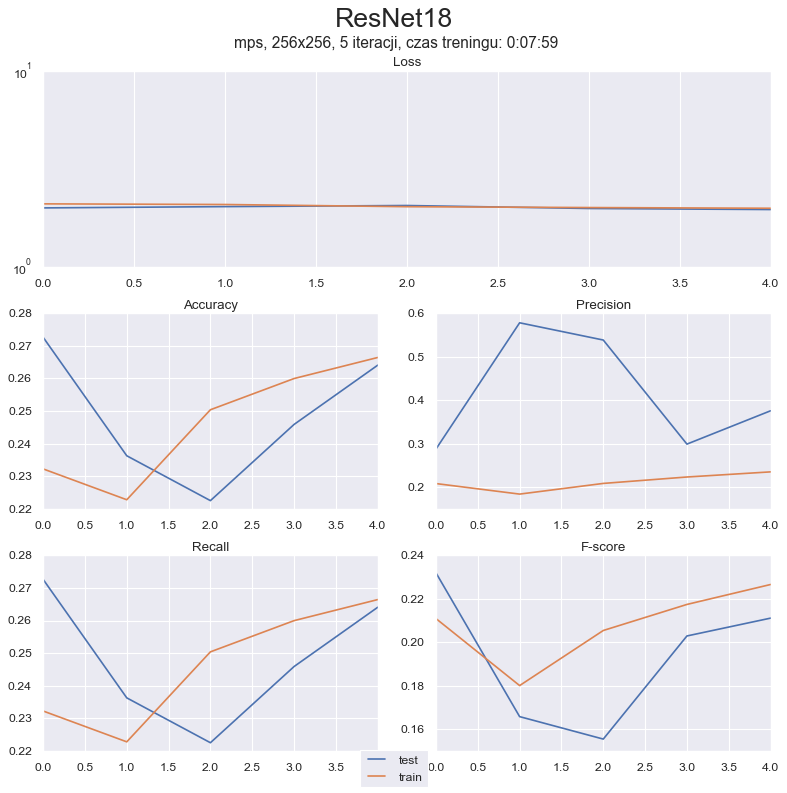

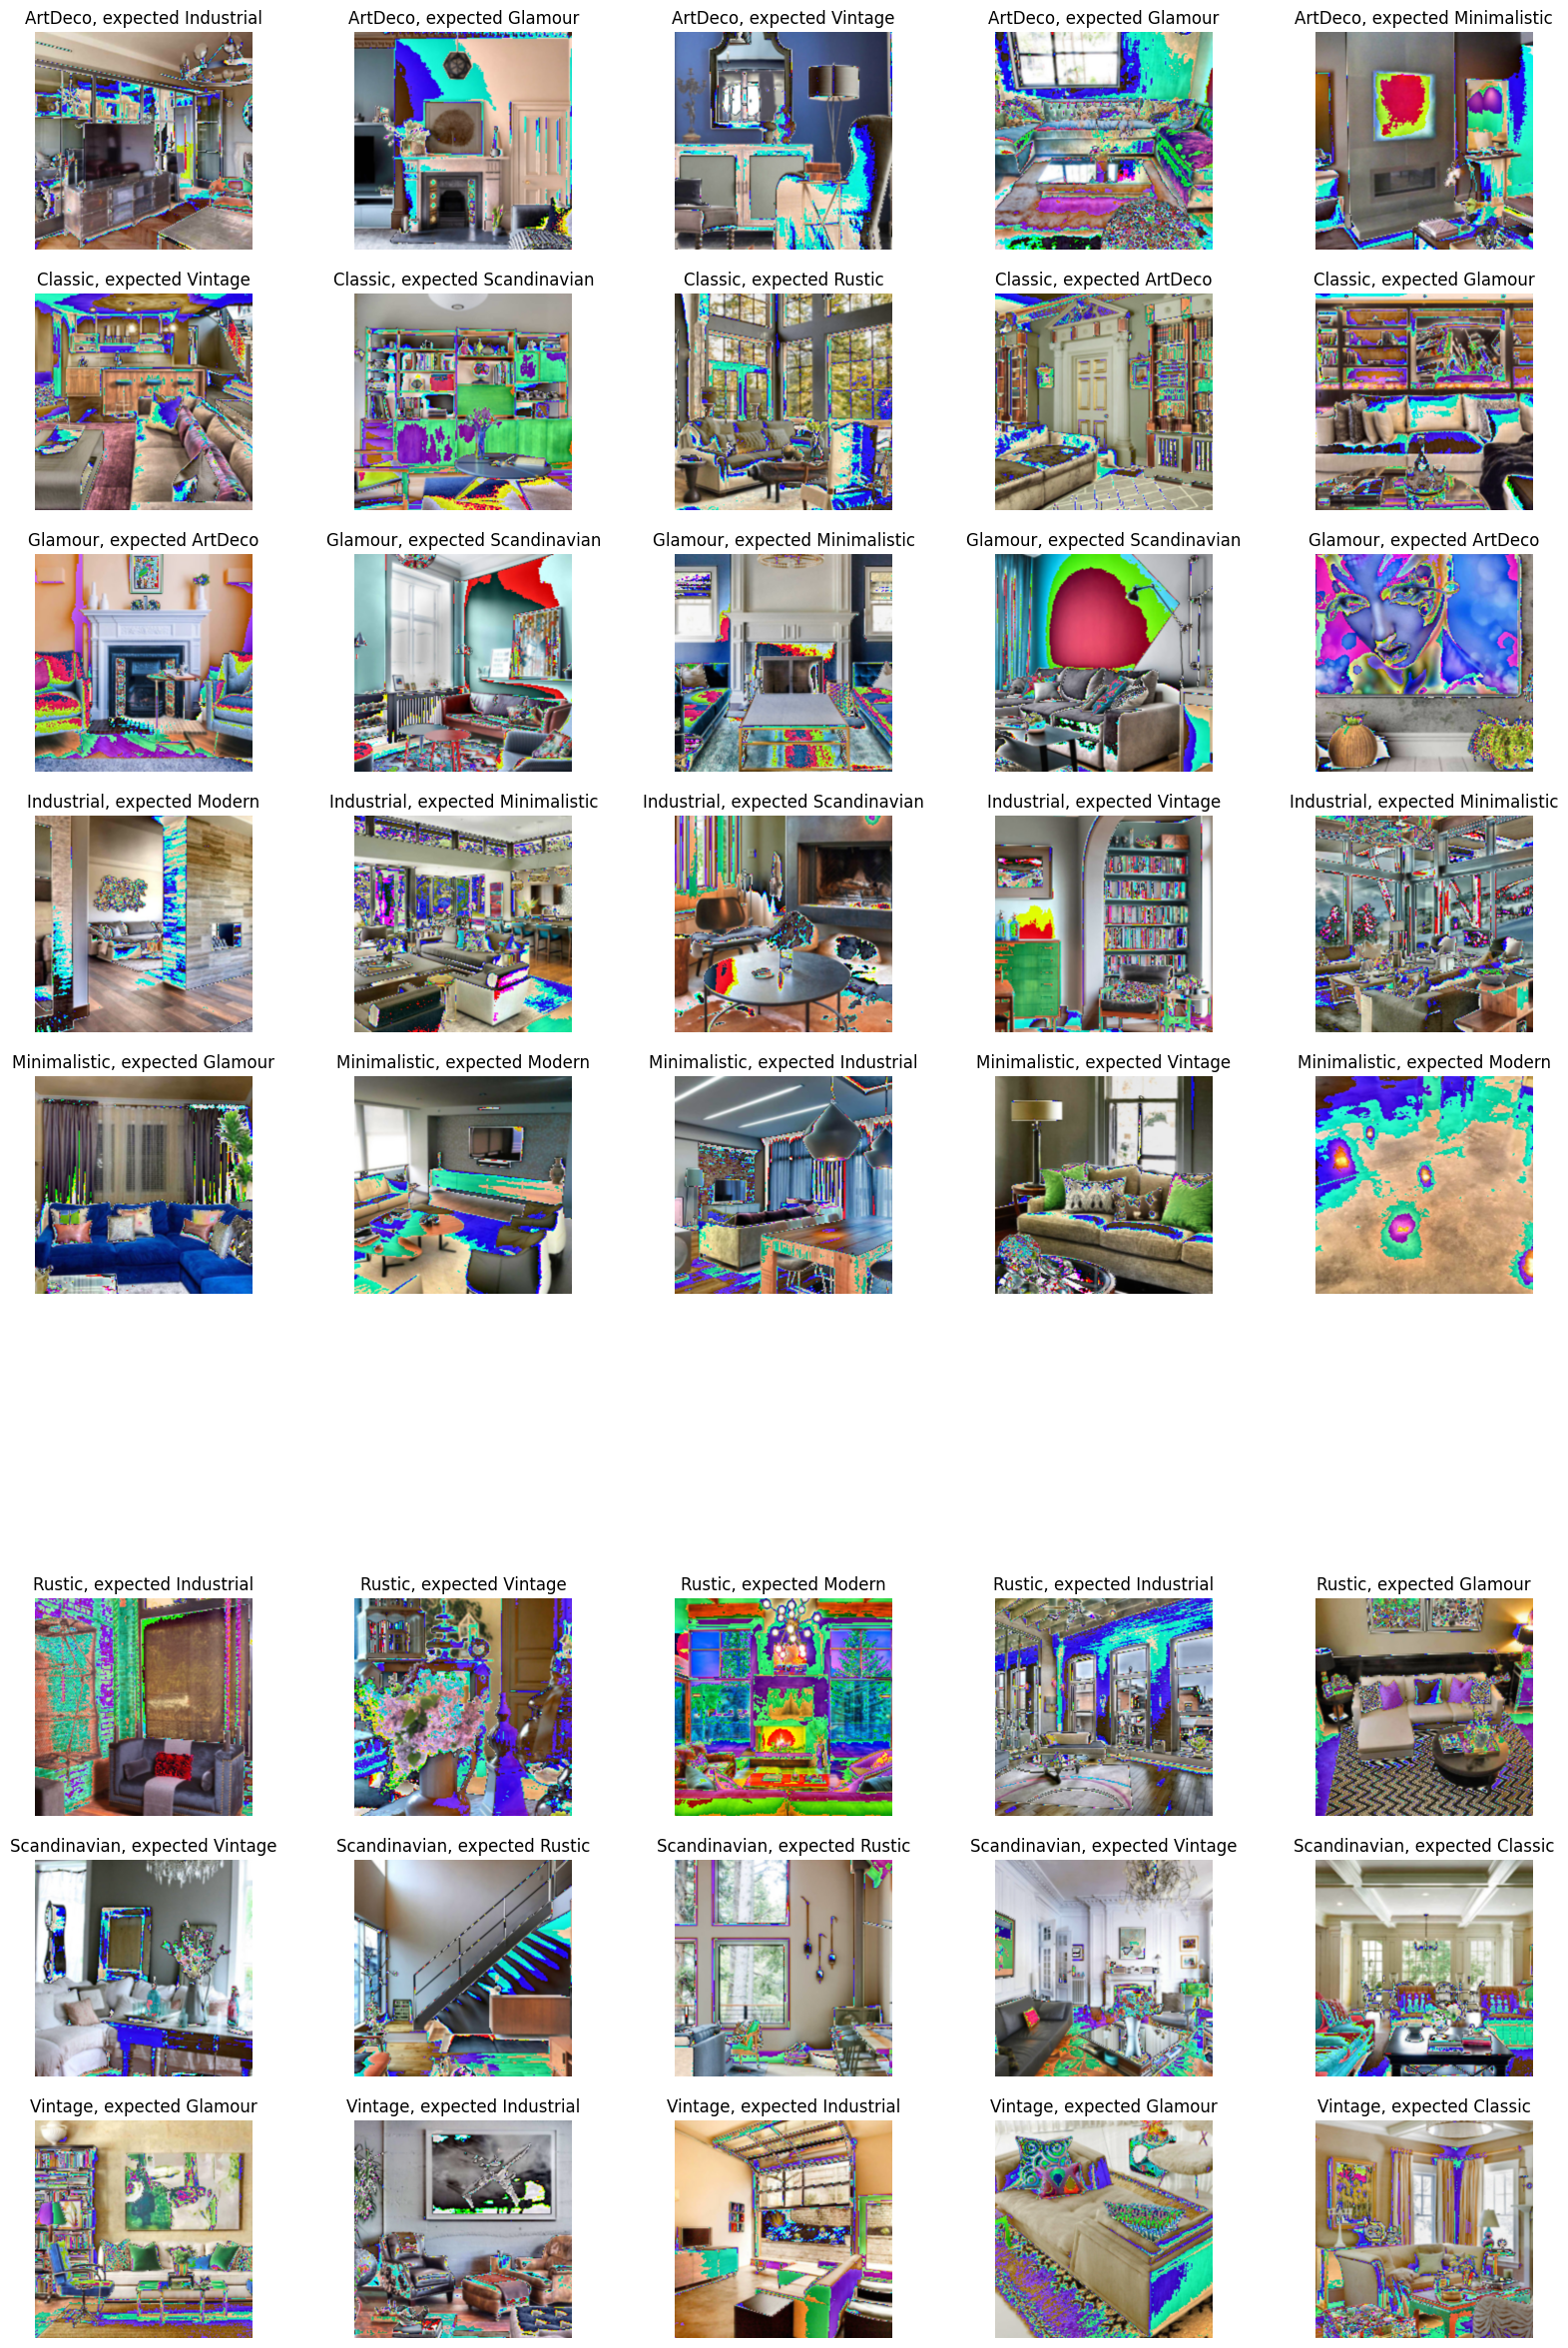

In [9]:
test_metrics, train_metrics = conduct_experiment("ResNet18", resnet_model, 5, torch.optim.Adam(resnet_model.parameters()))